In [3]:
# FR documentation: http://htrc.github.io/htrc-feature-reader/htrc_features/feature_reader.m.html#htrc_features.feature_reader.FeatureReader
from htrc_features import FeatureReader, Volume, Page
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Open EF files in directory tree and read into FeatureReader
rootdir = '/Users/mollytaylor/Downloads/ForUseInSchools'

paths_list = []
# reference: https://www.techiedelight.com/list-all-subdirectories-in-directory-python/
def find_file(rootdir):
    for child in os.scandir(rootdir):
        if child.is_dir():
            find_file(child.path)
        else:
            if child.name != '.DS_Store':
                paths_list.append(child.path)
                
find_file(rootdir)
fr = FeatureReader(paths_list)

# create array of volumes
all_volumes = []
for vol in fr.volumes():
    all_volumes.append(vol)

# read in csv of volumes in for use in schools collection
for_use_in_schools = pd.read_csv('/Users/mollytaylor/Downloads/ForUseinSchools.csv')

# get list of volumes that accounts for clusters
volumes = remove_duplicates(all_volumes)

98


# Remove Duplicates

In [2]:
# Return a list of volumes without duplicates (clusters) that appear in list all_volumes
def remove_duplicates(all_volumes):
    
    # sort all_volumes and for_use_in_schools by id 
    all_volumes.sort(key=lambda x: x.id)
    extracted = for_use_in_schools.sort_values(by='volume_id').reset_index(drop=True)
    
    # extracted should only contain volumes found by Extracted Features
    j = 0   
    for i, id in enumerate(extracted['volume_id']):
        if (id != all_volumes[j].id):
            extracted.drop(labels=[i], axis=0, inplace=True)
        else:
            j += 1
    
    # keep the duplicate with the most pages (that was found by Extracted Features)
    duplicates = extracted.loc[extracted['cluster'].notnull()].reset_index(drop=True)
    duplicates = duplicates[['volume_id', 'cluster', 'page_count']].sort_values(by='page_count').reset_index(drop=True)
    duplicates = duplicates.drop_duplicates(subset=['cluster'], keep='last')

    # get list of ids for updated volume workset 
    non_duplicates = extracted.loc[extracted['cluster'].isnull()].reset_index()
    keep = pd.concat([duplicates['volume_id'], non_duplicates['volume_id']])
    keep = keep.sort_values().reset_index(drop=True) 

    # create array of volumes in updated volume workset
    volumes = []
    i = 0
    for vol in all_volumes:
        if vol.id == keep[i]:
            volumes.append(vol)
            i += 1
        
    print(len(volumes))
    return volumes

remove_duplicates(all_volumes)

98


# Extracted Features Library

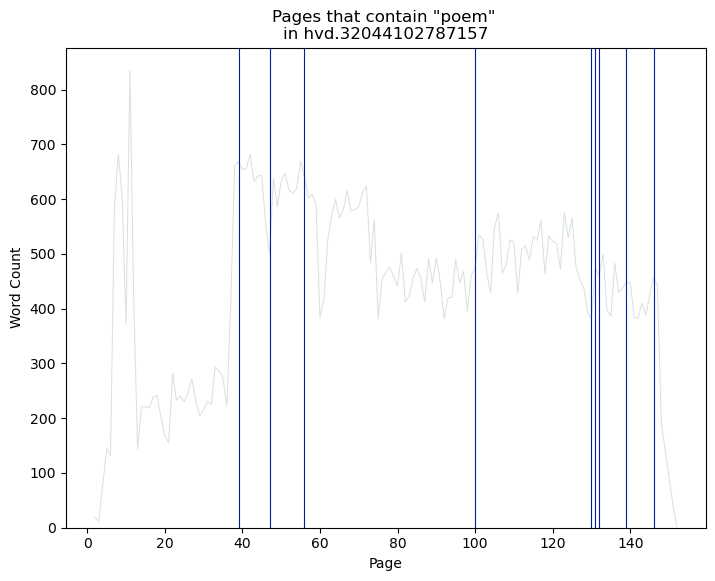

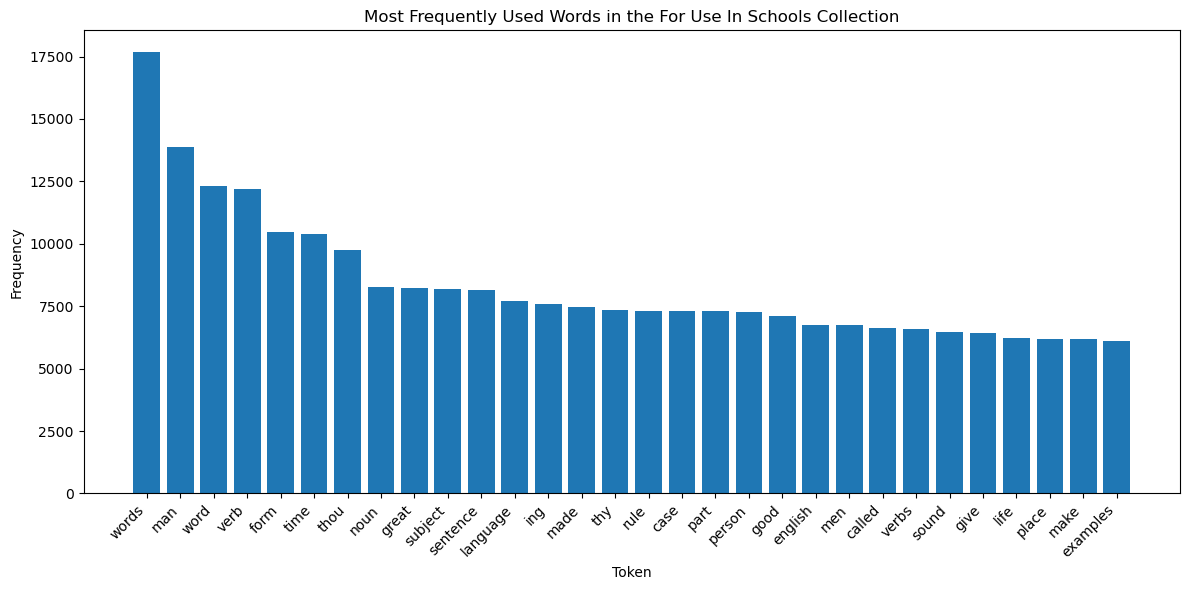

VB
      token  count
0      verb  10895
1      give   5662
2      make   4944
3     write   3534
4      note   2761
5   express   2055
6      find   1998
7     speak   1832
8      hear   1636
9      read   1599
10     call   1468
11     sing   1416
12      die   1271
13     form   1245
14     show   1235
15    bring   1195
16    stand   1069
17      put   1054
18     live   1051
19     love   1015
20    learn    946
21    leave    923
22     pass    877
23   follow    869
24    begin    836
25     bear    820
26     turn    812
27    agree    792
28   denote    786
29     fall    784


In [4]:
# Graph tokens per page of volume
def tpp(volume):
    tpp = volume.tokens_per_page()
    x = tpp.index
    y = tpp.values
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(x,y)
    ax.set_title(volume.id)
    ax.set_xlabel('Page')
    ax.set_ylabel('Word Count')

# Graph tokens per page of each volume in list volumes 
def tpp_set(volumes):
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    
    # set the number of columns for the legend
    num_cols = len(volumes)//4
    if num_cols < 1:
        num_cols = 1
    
    # set chart and axis titles
    ax.set_title('Word Count by Page')
    ax.set_ylabel('Word Count')
    ax.set_xlabel('Page')
    
    # plot tokens per page for each volume
    for volume in volumes:
        tpp = volume.tokens_per_page()
        ax.plot(tpp.index, tpp.values, label=volume.id)
        plt.legend(loc='upper left', fontsize = "10", bbox_to_anchor=(1, 1), ncol=num_cols)

# Graph a histogram of page counts of volumes in list volumes
def hist_page_counts(volumes):
    page_counts = []
    max_page_count = 0
    for volume in volumes:
        page_count = volume.page_count
        if page_count > max_page_count:
            max_page_count = page_count
        page_counts.append(page_count)
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    bins=[]
    for i in range(0, max_page_count+100, 50):
        bins.append(i)
    ax.hist(page_counts, bins, color='g', edgecolor = "black")
    ax.set_xlabel('Page Count')
    ax.set_ylabel('Number of Volumes')
    ax.set_title(f'Frequency of Page Counts' + '\n' + 'in the \'For Use in Schools\' Collection')
    
# Plot tokens per page of Volume volume and mark the pages that contain String token 
def pages_with_tokens(volume, token):
    # set up plot
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.set_title(f'Pages that contain "' + token + '" \nin ' + volume.id)
    ax.set_ylabel('Word Count')
    ax.set_xlabel('Page')
    
    # plot token count per page 
    tokens_per_page = volume.tokens_per_page()
    ax.plot(tokens_per_page, color='#dae1e3', linewidth = '.75')
    
    # plot tokens by page
    token_all = volume.tokenlist().reset_index()
    token_pages = token_all.loc[token_all['token'].str.lower() == token.lower()]
    
    # get page numbers for token pages
    page_numbers = token_pages['page']
    for page_number in page_numbers:
        ax.axvline(x=page_number, color='#051fa3', linewidth = '.8')
    
    ax.set_ylim(bottom=0)  # To ensure y-axis starts from 0
    plt.show()

pages_with_tokens(volumes[19], 'poem')    

# Show bar chart comparing the frequencies of String token1 
# and String token2 throughout Volume volume
def compare_tokens(volume, token1, token2):
    # need to adjust -- counting from 0!?
    
    # set up chart
    fig=plt.figure()
    ax=fig.add_axes([0,0,1.5,1])
    ax.set_title(f'Frequency of "' + token1 + '" and "' + token2+ '" \nacross volume ' + volume.id)
    ax.set_ylabel('Count')
    ax.set_xlabel('Pages (Groups of 20)')
    
    # get pages and count of token1 and token2
    all_tokens = volume.tokenlist().reset_index()
    token1_in_volume = all_tokens.loc[all_tokens['token'] == token1].reset_index(drop=True)
    token2_in_volume = all_tokens.loc[all_tokens['token'] == token2].reset_index(drop=True)
    count_by_page1 = [0] * volume.page_count
    count_by_page2 = [0] * volume.page_count
    
    # create arrays with index page number and value token count
    for i, page in enumerate(token1_in_volume["page"]):
        count_by_page1[page] = token1_in_volume.loc[i].at["count"]
    
    for i, page in enumerate(token2_in_volume["page"]):
        count_by_page2[page] = token2_in_volume.loc[i].at["count"]
        
    # group into 20-page clusters
    grouped1 = []
    grouped2 = []
    group_size = 20
    num_groups = volume.page_count // group_size + 1
    for i in range(num_groups):
        sum1 = 0
        sum2 = 0
        for j in range(group_size):
            index = j + (i * group_size)
            if index < len(count_by_page1):
                sum1 += count_by_page1[j + (i * group_size)]
                sum2 += count_by_page2[j + (i * group_size)]
        grouped1.append(sum1)
        grouped2.append(sum2)
    
    # create data
    x = np.arange(num_groups)
    width = .4
  
    # plot data in grouped manner of bar type
    plt.bar(x + width / 2, grouped1, width, color="blue", label=token1)
    plt.bar(x + width * 1.5, grouped2, width, color="orange", label=token2)

    # Set x-axis tick positions and labels
    plt.xticks(x, [f"{i}" for i in range(0, num_groups*group_size, group_size)], fontsize = 9, rotation=60, ha='right')
    
    # Show legend
    plt.legend(loc='upper left', fontsize="10", bbox_to_anchor=(1, 1), ncol=1)
    plt.show()

# Print the most frequently used tokens in Volume list volumes 
def print_common_tokens(volumes):
    all_tokens = []
    
    # Loop through each volume and get the term frequencies
    for volume in volumes:
        tokens = volume.term_volume_freqs(page_freq=False)
        tokens = tokens[tokens['token'].str.isalpha()]
        all_tokens.append(tokens)

    # Concatenate all the DataFrames
    total = pd.concat(all_tokens, ignore_index=True)

    # Convert 'count' column to numeric type (integer)
    total['count'] = pd.to_numeric(total['count'])
    total['token'] = total['token'].str.lower()
    
    # Group by token and sum the term frequencies while keeping the 'pos' column
    total = total.groupby(['token'], as_index=False).agg({'count': 'sum'})
    
    # load stop words
    file = open('/Users/mollytaylor/Downloads/stopwords.txt', 'r')
    data = file.read()
    stopwords = data.split('\n')
    file.close()
    
    # remove stop words
    total = total[~total['token'].isin(stopwords)].sort_values(by='count', ascending=False)
    total = total.reset_index(drop=True)
    # Take the top 20 rows for plotting
    
    top = total.head(30)

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(top['token'], top['count'])

    # Set plot labels and title
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title(f'Most Frequently Used Words in the For Use In Schools Collection')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return total
        
# Print the most frequently used tokens, by Penn part of speech pos, in Volume list volumes 
def common_tokens_by_pos(volumes, pos):
    all_tokens = []
    
    # Loop through each volume and get the term frequencies
    for volume in volumes:
        tokens = volume.term_volume_freqs(page_freq=False)
        tokens = tokens[tokens['token'].str.isalpha()]
        tokens = tokens[tokens['pos'].isin([pos])]
        all_tokens.append(tokens)

    # concatenate all the DataFrames
    total = pd.concat(all_tokens, ignore_index=True)

    # convert 'count' column to numeric type (integer) and 'token' column to lowercase
    total['count'] = pd.to_numeric(total['count'])
    total['token'] = total['token'].str.lower()
    
    # group by token and sum the term frequencies while keeping the 'pos' column
    total = total.groupby(['token'], as_index=False).agg({'count': 'sum'})
    
    # load stop words
    file = open('/Users/mollytaylor/Downloads/stopwords.txt', 'r')
    data = file.read()
    stopwords = data.split('\n')
    file.close()
    
    # load replacement rules
    # file = open('/Users/mollytaylor/Downloads/replacement_rules.txt', 'r')
    # data = file.read()
    # replacement_rules = data.split('\n')
    # file.close()
    
    # remove tail and stop words
    total = total[total['count']>500].reset_index(drop=True)
    total = total[~total['token'].isin(stopwords)].sort_values(by='count', ascending=False).reset_index(drop=True)
    
    print(pos)
    print(total.head(30))

common_tokens_by_pos(volumes, 'VB')   

        

# Named Entities

187
83


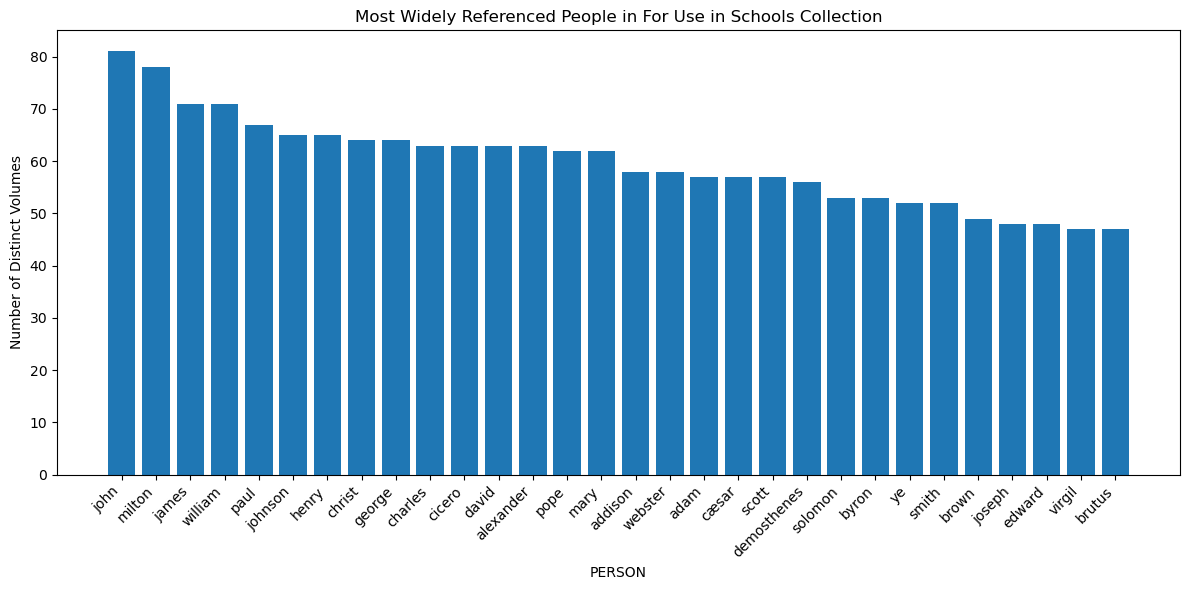

         Entity  Number of Volumes  Frequency
0          john                 81       1913
1        milton                 78        871
2         james                 71        806
3       william                 71        582
4          paul                 67        335
5       johnson                 65        595
6         henry                 65        498
7        christ                 64        229
8        george                 64        368
9       charles                 63        441
10       cicero                 63        391
11        david                 63        264
12    alexander                 63        237
13         pope                 62        564
14         mary                 62        386
15      addison                 58        299
16      webster                 58        490
17         adam                 57        141
18        cÃ¦sar                 57        343
19        scott                 57        319
20  demosthenes                 5

In [6]:
# Returns dataframe with named entities from For Use in Schools Collection. The dataframe excludes entries 
# from duplicate volumes, pronouns, and non-alphanumeric tokens. 
def clean_named_entites():
    ne = pd.read_csv('/Users/mollytaylor/Downloads/entities_original.csv', 
                     index_col="vol_id").sort_index()

    # create dataframe with volumes that belong to a cluster
    duplicates = for_use_in_schools.loc[for_use_in_schools['cluster'].notnull()].reset_index(drop=True)
    duplicates = duplicates[['volume_id', 'cluster', 'page_count']].sort_values(
        by=['cluster', 'page_count'], ascending=(False, False)).reset_index(drop=True)

    # populate remove list with voume ids that belong to duplicate volumes, 
    # keeping the longest volume in each cluster
    prev, remove = '', []
    for i, id in enumerate(duplicates['volume_id']):
        cluster = duplicates.loc[i].at['cluster']
        if (cluster == prev):
            remove.append(id)
        prev = cluster
    print(len(for_use_in_schools['volume_id']))
    print(len(remove))
    # remove entries from duplicate volumes from named entites dataframe
    ne = ne.loc[~ne.index.str.lower().isin(remove)]
    
    # remove non-alphanumeric tokens and pronouns from named entities dataframe
    ne = ne.loc[ne["entity"].str.isalnum()]
    pronouns = ("she", "her", "hers", "him", "his", "he", "their", "they", "theirs")
    ne = ne.loc[~ne["entity"].str.lower().isin(pronouns)].reset_index()
    
    return ne


# Returns a series with the named entities of specified type (if provided) that 
# appear at least once in the greatest number of volumes in Dataframe ne and
# plots results
def top_entities(ne, type='ALL'):
    if type != 'ALL':
        ne = ne.loc[(ne["type"]) == type]

    # Skip title pages
    ne = ne.loc[ne["page_seq"] > 5]

    # Convert all entities to lowercase
    ne['entity'] = ne['entity'].str.lower()

    # Get sorted series with the named entities of the greatest frequency
    word_count = ne["entity"].value_counts()

    # Get sorted series with the named entities in the greatest number of distinct volumes
    vol_count=ne.drop_duplicates(subset = ['vol_id', 'entity'], keep='first').reset_index(drop=True)
    vol_count = vol_count["entity"].value_counts().sort_values(ascending=False)
    
    # Sort Series word_count based on the indices of vol_count
    word_count = word_count.reindex(vol_count.index)
    
    # Create a dataframe with the most widely used entities and their frequencies
    top_entities = pd.DataFrame(list(zip(vol_count.index, vol_count.values, word_count.values)),
               columns =['Entity', 'Number of Volumes', 'Frequency'])
        
    # Take the top 20 rows for plotting
    top = top_entities.head(30)

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(top['Entity'], top['Number of Volumes'])

    # Set plot labels and title
    plt.xlabel(type)
    plt.ylabel('Number of Distinct Volumes')
    plt.title(f'Most Widely Referenced People in For Use in Schools Collection')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return top_entities

print((top_entities(clean_named_entites(), "PERSON")).head(50))



# (Do Not Use) Writing poetry_finder()

In [15]:
def __uppercase_id(volume): 
    start_chars = volume.begin_line_chars().reset_index()
    length = volume.page_count
    
    # Find the percent of uppercase start chars on each page
    upper_to_lower = []
    for i in range(1, length + 1):
        page_chars = start_chars[start_chars['page'] == i]
        lower_chars = page_chars['char'].str.islower().sum()
        upper_chars = page_chars['char'].str.isupper().sum() 
        if lower_chars > 0:
            upper_to_lower.append(upper_chars / lower_chars) 
        else: 
            upper_to_lower.append(0)

    # Create dataframe with the percent of uppercase start chars per page
    data = {'page': np.arange(1, length + 1), 'upper to lower': upper_to_lower}
    uppercase_by_page = pd.DataFrame(data)
    
    # Get the mean, stddev, and median of uppercase start chars per page
    avg = uppercase_by_page['upper to lower'].mean()
    stddev = uppercase_by_page['upper to lower'].std()
    median = uppercase_by_page['upper to lower'].median()
    
    # Calculate baseline ratio upper : lower
    base = 1
    
    # Find the pages above the baseline
    uppercase_id = uppercase_by_page[uppercase_by_page['upper to lower'] >= base]
    uppercase_id =  uppercase_id.reset_index(drop=True)
    
    print(f"Median uppercase: {median}")
    print(f"Average uppercase: {avg}")

    return uppercase_id

def __end_char_id(volume): 
    start_chars = volume.end_line_chars().reset_index()
    length = volume.page_count
    
    # Find the ratio of comma end chars
    commas = {}
    for i in range(1, length + 1):
        page_chars = start_chars[start_chars['page'] == i]
        print(page_chars)
        total_chars = page_chars['count'].sum()
        comma_ct = page_chars
        #df2=df[df['Fee']==22000]['Courses'].values[0]
        if i == 33:
            print(comma_ct)
        num_ct = (page_chars['char'].str.isnumeric()).sum() 
        if total_chars > 0:
            commas[i] = ((comma_ct + num_ct) / total_chars *100) 
        else: 
            commas[i] = 0

    # Convert the dictionary to a DataFrame
    commas_by_page = pd.DataFrame(commas.items(), columns=['page', 'percent commas'])
   
    # Get the mean, stddev, and median of numeric end chars per page
    avg = commas_by_page['percent commas'].mean()
    stddev = commas_by_page['percent commas'].std()
    median = commas_by_page['percent commas'].median()
    
    # Calculate baseline number of commma end line characters 
    base = int(median)
    
    # Find the pages above the baseline 
    comma_id = commas_by_page[commas_by_page['percent commas'] >= base]
    comma_id = comma_id.reset_index(drop=True)
    
    print(f"Median num: {median}")
    print(f"Average num: {avg}")

    return comma_id
    
def __lines_per_sentence(volume):
    sentence_counts = volume.sentence_counts()
    line_counts = volume.line_counts()

    ratio = {} 
    for page in sentence_counts.index:
        if not np.isnan(sentence_counts[page]):
            ratio[page] = line_counts[page] / sentence_counts[page]
        else:
            ratio[page] = np.nan  # Use np.nan instead of NaN
    
    # Create a Dataframe with the ratio tokens : sentence
    ratio = pd.DataFrame(list(ratio.items()), columns=['page', 'lines per sentence'])

    # get the mean and stddev of sentence counts by page
    avg = ratio['lines per sentence'].mean()
    stddev = ratio['lines per sentence'].std()
    median = ratio['lines per sentence'].median()
    
    # calculate baseline ratio
    base = 1.5
        
    ratio_page = ratio.loc[ratio['lines per sentence'] >= base]
    
    print()
    print(f"Median ratio: {median}")
    print(f"Average ratio: {avg}")
    print(f"Stddev ratio: {stddev}")
    print()
    
    return ratio_page.reset_index(drop=True)
    
def __sentence_id(volume):
    sentence_counts = volume.sentence_counts()

    # Get the mean and stddev of sentence counts by page
    avg = sentence_counts.mean()
    stddev = sentence_counts.std()
    median = sentence_counts.median()
    
    # Calculate baseline number of sentences 
    base = int(median + stddev)
    
    # Print stats
    print()
    print(f"Average sentence count: {avg} ")
    print(f"Median sentence count: {median} ")
    print(f"Base sentence count: {base}")
    print()
    
    # Creating a dictionary by passing Series objects as values
    frame = {'Page': sentence_counts.index, 'Sentence Count': sentence_counts.values}
 
    # Creating DataFrame by passing Dictionary
    sentence_id = pd.DataFrame(frame)
    sentence_id = sentence_id.loc[sentence_id['Sentence Count'] <= base]
 
    return sentence_id.reset_index(drop=True)

def __token_id(volume):
    token_counts = volume.tokens_per_page().reset_index()

    # filter out pages with < 100 tokens
    token_counts = token_counts.loc[token_counts['tokenCount'] > 150].reset_index(drop=True)

    # get the mean and stddev of sentence counts by page
    avg = token_counts['tokenCount'].mean()
    stddev = token_counts['tokenCount'].std()
    median = token_counts['tokenCount'].median()
    
    # calculate baseline number of tokens 
    base = int(median - stddev + 150)
    
    # Print stats
    print()
    print(f"Average token count: {avg} ")
    print(f"Median token count: {median} ")
    print(f"Base token count: {base}")
    print()
    
    token_id = token_counts.loc[token_counts['tokenCount'] <= base]
    return token_id.reset_index(drop=True)

def __sentences_per_tokens(volume):
    sentence_counts = volume.sentence_counts()
    token_counts = volume.tokens_per_page()

    total = {} 
    for page in sentence_counts.index:
        if not np.isnan(sentence_counts[page]):
            total[page] = token_counts[page] / sentence_counts[page]
        else:
            total[page] = np.nan  # Use np.nan instead of NaN
    
    # Create a Dataframe with the ratio tokens : sentence
    ratio = pd.DataFrame(list(total.items()), columns=['page', 'tokens per sentence'])

    # get the mean and stddev of sentence counts by page
    avg = ratio['tokens per sentence'].mean()
    stddev = ratio['tokens per sentence'].std()
    median = ratio['tokens per sentence'].median()
    
    # calculate baseline ratio
    base = int(median)
        
    ratio_page = ratio.loc[ratio['tokens per sentence'] <= base]
    
    print()
    print(f"Median ratio: {median}")
    print(f"Average ratio: {avg}")
    print(f"Stddev ratio: {stddev}")
    print()
    print(ratio_page.head(50))
    
    return ratio_page.reset_index(drop=True)

def find_poetry(volume):
    # sentences = __sentence_id(volume)
    # uppercase = __uppercase_id(volume)
    # tokens = __token_id(volume)
    end = __end_char_id(volume)
    print(end.head(60))
    lines_per_sentence = __lines_per_sentence(volume)
    # print(lines_per_sentence.head(60))
    # poetry_id = (set(uppercase['page']) & set(tokens['page']) 
               # & set(sentences['Page']) & set(end['page']))
    # poetry_id = (set(uppercase['page']) & set(end['page']))
    
    pg = 19
    case = pg in set(uppercase['page'])
    sentence = pg in set(sentences['Page'])
    tokens = pg in set(tokens['page'])
    end_char = pg in set(end['page'])
    
    print()
    print(f"Uppercase: {case}")
    print(f"Sentence: {sentence} ")
    print(f"Tokens: {tokens} ")
    print(f"End chars: {end_char} ")

    #end_value = end.loc[end['page'] == 11, 'percent number'].values[0]
    #print(f"Percent numeric end chars: {end_value} ")

    poetry_id = sorted(poetry_id)
    
    print(len(poetry_id))
    print(poetry_id)

n = 20
print(volumes[n].id)
find_poetry(volumes[n])
print(volumes[n].id)
# want to test nyp.33433082522537

hvd.32044102845823
   page section place char  count
0     1    body   end    |      1


TypeError: can only concatenate str (not "int") to str

# Testing

98


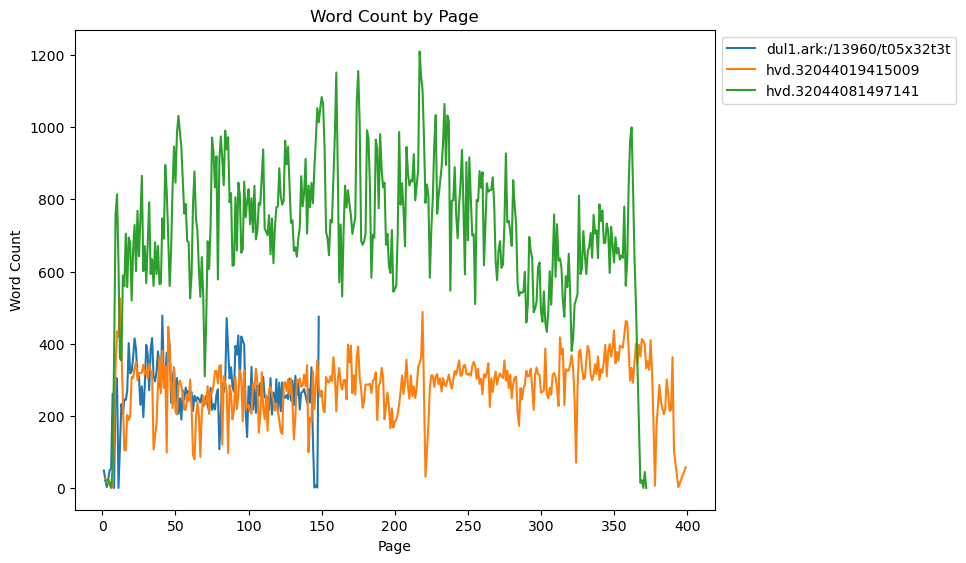

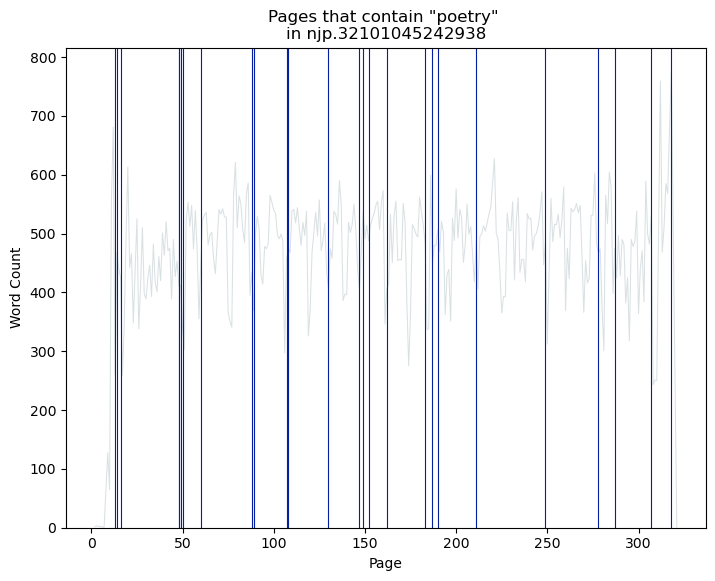

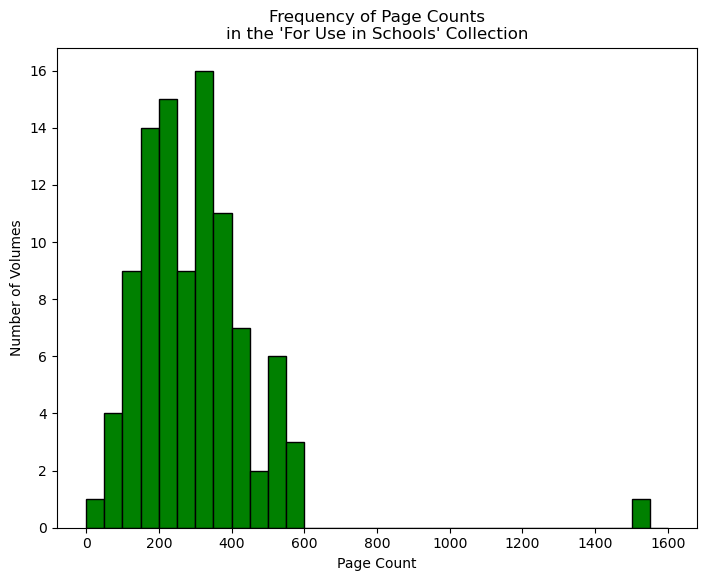

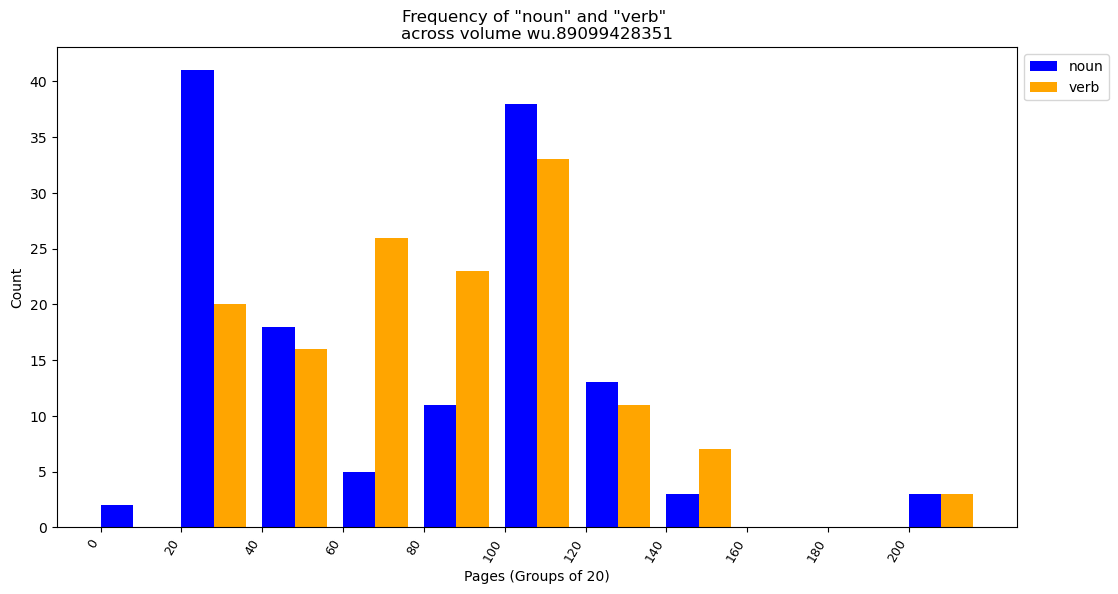

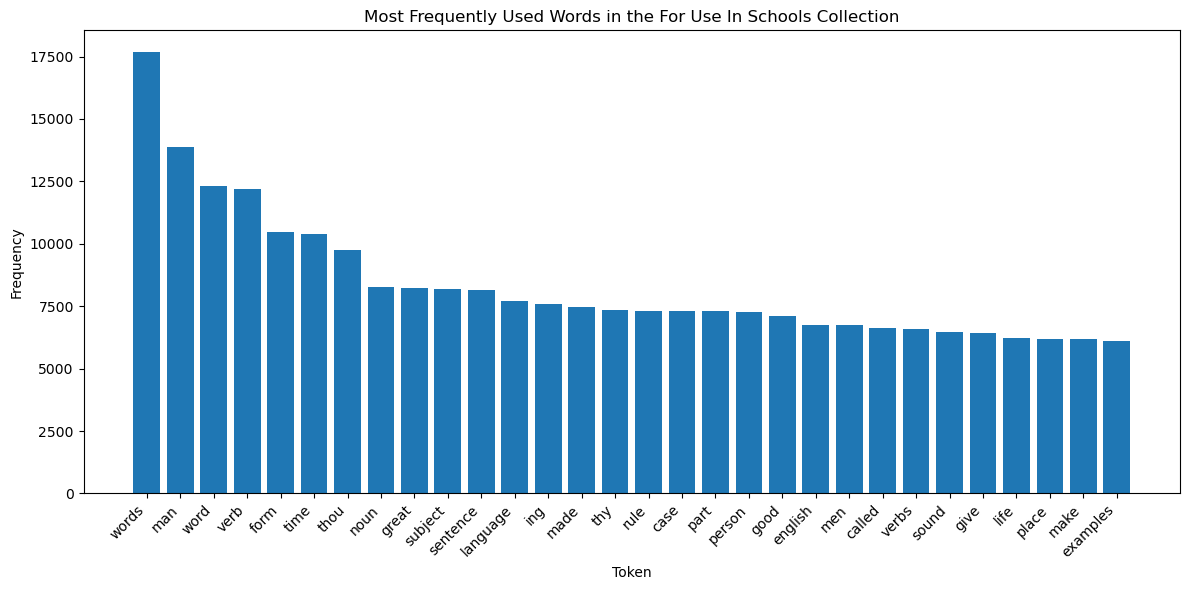

NameError: name 'get_token_in_volume' is not defined

In [11]:
# Testing 
print(len(volumes))
tpp_set([volumes[i] for i in range(3)])
pages_with_tokens(volumes[45], 'poetry')
hist_page_counts(volumes)
compare_tokens(volumes[89], 'noun', 'verb')
print_common_tokens(volumes)
# get_token_in_volume(volumes[19], 'poem')


# Frequency in Volume by https://github.com/ds-modules/Library-HTRC/blob/master/02-viz/02-HTRC-Token-Correlation.ipynb 

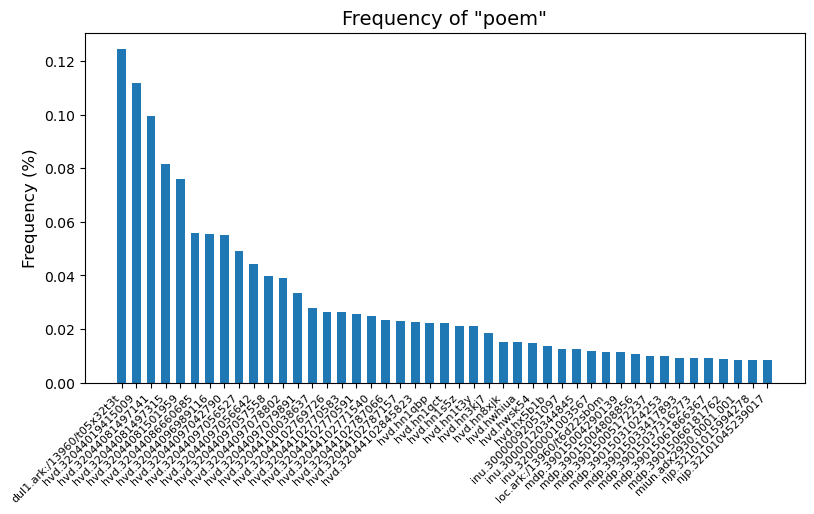

In [7]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation

# Return the usage frequency of a given word in a given volume. 
# NOTE: frequency() returns a dictionary entry of the form {'word': frequency}.
# e.g. frequency(fr_novels.first(), 'blue') returns {'blue': 0.00012}

def frequency(vol, word):
    tokens = vol.tokenlist(pages=False, pos=False, case=False).reset_index()
    
    # Load stop words
    file = open('/Users/mollytaylor/Downloads/stopwords.txt', 'r')
    data = file.read()
    stopwords = data.split('\n')
    file.close()
    
    punctuation = [',', '.', '--', '(', ')', ';', '\'\'', '!']
    # Exlude stopwords and punctuation
    tokens = tokens.loc[~tokens['lowercase'].isin(stopwords)]
    tokens = tokens.loc[~tokens['lowercase'].isin(punctuation)]
    tokens = tokens.loc[tokens['lowercase'].str.isalpha()]
    
    tokens = tokens.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    # Calculate token count and total count
    token_count = tokens.loc[tokens['lowercase'] == word]['count'].sum()
    total = tokens['count'].sum()

    freq = token_count/total
    
    return {word: freq}


# Returns a plot of the usage frequencies of the given word across all volumes in the given FeatureReader collection.
# NOTE: frequencies are given as percentages rather than true ratios.
def frequency_bar_plot(word, fr):
    freqs, ids = [], []
    for vol in fr:
        id = vol.id
        freqs.append(100 * frequency(vol, word)[word])
        ids.append(id)

    # Sort lists in descending order by frequency
    freqs.sort(reverse=True)
    freqs = freqs[:45]
    ids = ids[:45]

    # Create x_ticks with the appropriate length
    x_ticks = np.arange(len(ids))
    
    # Adjust the bar width and spacing
    bar_width = 0.6  # Adjust this value to control the width of the bars
    x_ticks_shifted = np.arange(len(ids)) - (bar_width * (len(ids) - 1)) / 2
    
    # Format and plot the data
    plt.figure(figsize=(12, 5))
    plt.bar(x_ticks_shifted, freqs, width=bar_width)
    plt.xticks(x_ticks_shifted, ids, fontsize=8, rotation=45, ha='right')  # Align labels to the right
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.title('Frequency of "' + word + '"', fontsize=14)

    plt.tight_layout()  # Automatically adjust the layout to prevent clipping
    plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)  # Adjust margins and spacing

    plt.show()

token = "poem"    
frequency(volumes[79], token)
frequency_bar_plot(token, volumes)

# Finding Tokens

In [440]:
def get_token_in_volume(volume, token, do_print=False):
    tokens = volume.tokenlist().reset_index()
    pages = tokens.loc[tokens['token'].str.lower() == token.lower()].reset_index(drop=True)
    token_pages = pages[['page', 'count']]
    
    # Get token count and page count
    token_ct = pages['count'].sum()
    page_ct = pages.page.nunique()
   
    # Print results 
    if do_print:
        print(f"'{token}' appears {token_ct} times on {page_ct} distinct pages"
              f" in volume {volume.id}.")
        print("Page       Frequency")
        for i in range(len(token_pages)):
            spacing = '{: <11}'.format(token_pages.loc[i, 'page'])
            print(f"{spacing}{token_pages.loc[i, 'count']}")
      
    return [volume.id, token_ct, page_ct, token_pages['page'].values.tolist()]

def get_token_in_volumes(volumes, token):
    profiles = pd.DataFrame(columns=["Volume ID", "Token Count", "Number of Pages", "Pages"])
    
    for volume in volumes:
        vol_info = get_token_in_volume(volume, token)
        profiles = profiles.append(pd.Series(vol_info, index=profiles.columns), ignore_index=True)
    
    # Filter out volumes that do not contain token
    profiles = profiles.loc[profiles['Number of Pages'] > 0]
    
    print(f"Token appears on {profiles['Number of Pages'].sum()} distinct pages across {len(profiles)} volumes.")
    return profiles

# Find volume pages that include all tokens in list tokens
def get_tokens_in_volume(volume, tokens):
    common_pages = None  # Initialize as None
    
    for token in tokens:
        token_pages = set(get_token_in_volume(volume, token)[3])
        
        if common_pages is None:
            common_pages = token_pages
        else:
            common_pages = common_pages.intersection(token_pages)
    
    return set(common_pages)

def get_tokens_in_volumes(volumes, tokens):
    # Populate common_pages with first volume 
    common_pages = pd.DataFrame(columns=["Volume ID", "Number of Pages", "Pages"])
    
    for volume in volumes:
        token_pages = get_tokens_in_volume(volume, tokens)
        vol_info = [volume.id, len(token_pages),token_pages]
        common_pages = common_pages.append(pd.Series(vol_info, index=common_pages.columns), ignore_index=True)
    
    common_pages = common_pages.loc[common_pages['Number of Pages'] > 0]
    common_pages.sort_values(by='Number of Pages', ascending=False, inplace=True)
    print(f"Tokens appear together on {common_pages['Number of Pages'].sum()} distinct pages across {len(common_pages)} volumes.")
    return common_pages

def get_tokens_in_volumes_or(volumes, tokens):
    common_pages = pd.DataFrame(columns=["Volume ID", "Number of Pages", "Pages"])
    
    for volume in volumes:
        pages = []
        for token in tokens:
            token_info = get_token_in_volume(volume, token)
            
            if token_info[1] > 0:
                for page in token_info[3]:
                    if page not in pages:
                        pages.append(page)
            
        vol_info = [volume.id, len(pages), pages]
        common_pages = common_pages.append(pd.Series(vol_info, index=common_pages.columns), ignore_index=True)
                
    common_pages = common_pages.loc[common_pages['Number of Pages'] > 0]
    common_pages = common_pages.sort_values(by='Number of Pages', ascending=False).reset_index(drop=True)

    return common_pages.head(30)

#get_tokens_in_volumes(volumes, ['annabel', 'lee'])
get_tokens_in_volumes_or(volumes, ['pray', 'church', 'faith'])


Volume ID Number of Pages  \
0   inu.30000092051097              80   
1      nnc1.cu58412921              72   
2   nyp.33433082522537              66   
3   hvd.32044100038637              59   
4   mdp.39015031024253              57   
5   nyp.33433069241762              54   
6   hvd.32044086660685              47   
7   mdp.39015005172237              45   
8           hvd.hn1qct              44   
9   njp.32101045239017              41   
10  nyp.33433082513510              39   
11  njp.32101063584419              36   
12  hvd.32044019415009              36   
13  hvd.32044081497141              36   
14  nyp.33433069246597              35   
15  nyp.33433066604632              34   
16  hvd.32044081501959              34   
17  hvd.32044096989116              30   
18  nyp.33433069240673              29   
19      wu.89099900573              28   
20     nnc1.cu58482440              28   
21  mdp.39015066181762              27   
22  njp.32101045242938              27   
23  nyp.33433082527494              27   
24  nyp.33433069257172              26   
25  nyp.33433069257156              25   
26  njp.32101074757137              24   
27  njp.32101072898404              24   
28  nyp.33433082511613              23   
29  nyp.33433043890163              23   

                                                Pages  
0   [57, 87, 112, 137, 237, 302, 329, 336, 338, 34...  
1   [11, 89, 91, 97, 98, 100, 103, 113, 119, 151, ...  
2   [24, 26, 28, 31, 32, 48, 51, 53, 59, 60, 62, 6...  
3   [82, 411, 552, 653, 660, 668, 808, 1118, 1330,...  
4   [137, 257, 333, 338, 21, 29, 37, 54, 80, 83, 8...  
5   [54, 230, 263, 316, 365, 366, 367, 392, 414, 5...  
6   [120, 316, 14, 22, 25, 30, 46, 70, 72, 75, 79,...  
7   [50, 77, 85, 98, 102, 134, 145, 193, 243, 298,...  
8   [121, 180, 216, 252, 282, 300, 307, 333, 336, ...  
9   [34, 46, 47, 59, 94, 123, 130, 166, 179, 188, ...  
10  [187, 189, 201, 208, 235, 273, 364, 26, 54, 58...  
11  [56, 158, 208, 262, 265, 266, 267, 292, 149, 1...  
12  [101, 108, 149, 150, 151, 195, 226, 248, 298, ...  
13  [54, 93, 95, 108, 197, 343, 14, 18, 32, 72, 85...  
14  [60, 87, 88, 120, 148, 150, 226, 227, 251, 277...  
15  [131, 132, 135, 136, 153, 161, 163, 164, 201, ...  
16  [44, 77, 78, 110, 212, 274, 288, 340, 376, 426...  
17  [173, 207, 211, 284, 287, 297, 302, 324, 335, ...  
18  [139, 159, 179, 194, 243, 245, 285, 56, 57, 61...  
19  [88, 328, 329, 330, 345, 404, 426, 445, 69, 11...  
20  [89, 126, 128, 175, 181, 365, 171, 217, 273, 2...  
21  [308, 27, 28, 29, 97, 98, 142, 144, 146, 159, ...  
22  [77, 78, 79, 132, 136, 137, 169, 174, 292, 294...  
23  [38, 74, 98, 160, 228, 250, 292, 198, 199, 215...  
24  [104, 204, 216, 277, 278, 292, 335, 31, 67, 18...  
25  [108, 208, 220, 281, 282, 296, 339, 33, 71, 19...  
26  [16, 33, 127, 179, 71, 75, 98, 120, 140, 146, ...  
27  [35, 167, 168, 27, 34, 37, 44, 47, 56, 120, 12...  
28  [32, 50, 140, 265, 320, 52, 100, 120, 126, 141...  
29  [50, 54, 153, 220, 347, 348, 349, 18, 43, 179,...

# Plot Token Dispersion

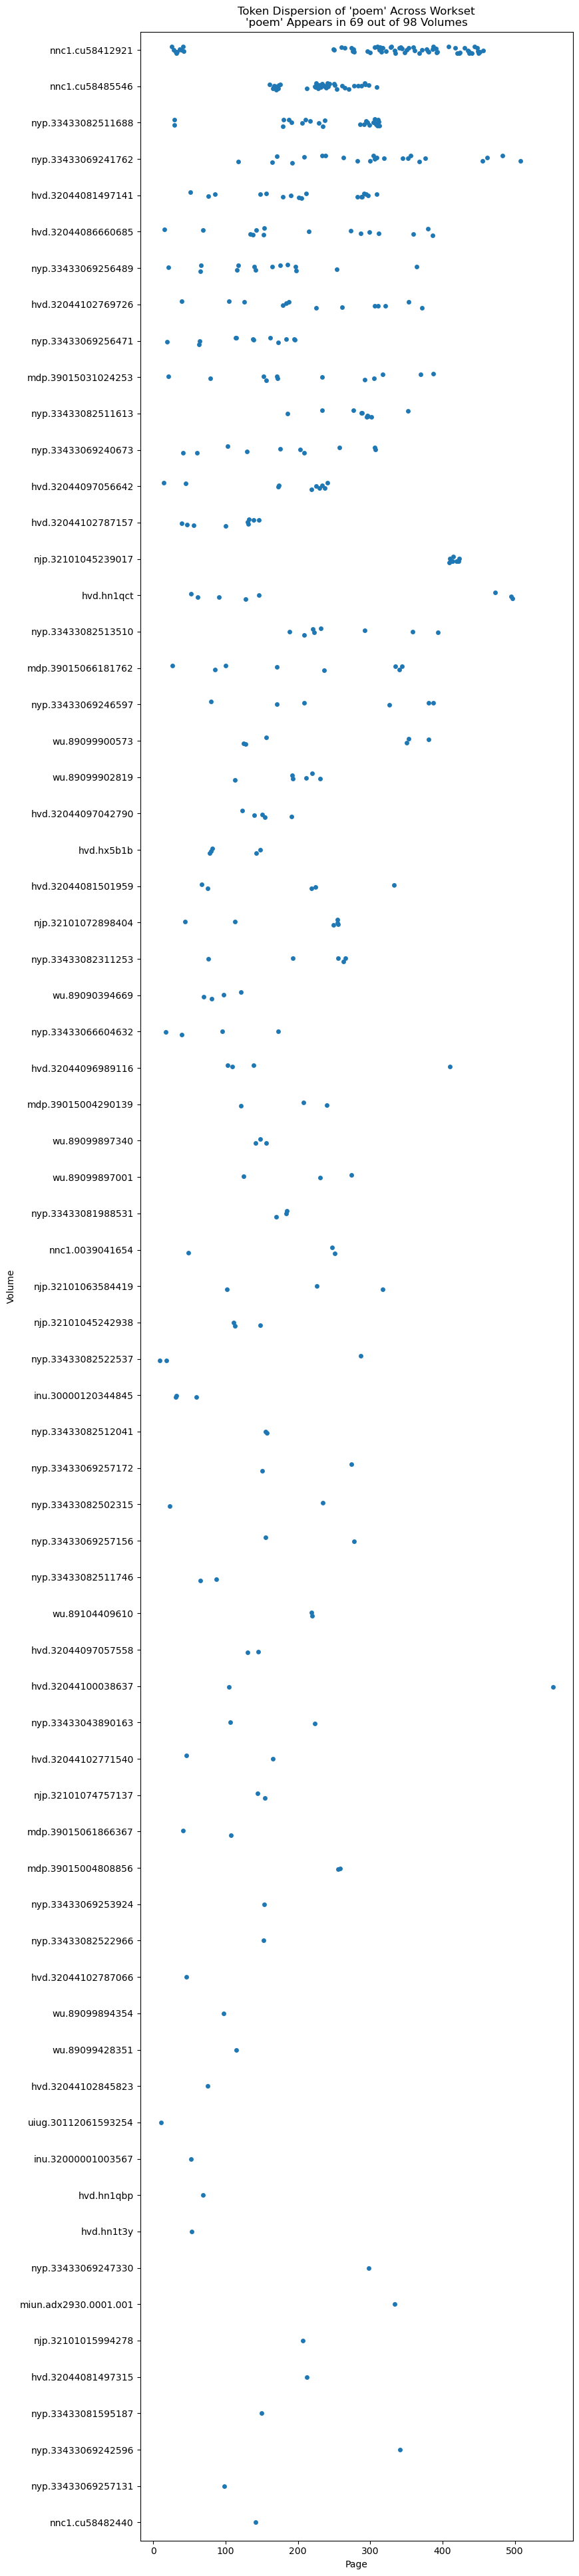

In [8]:
def plot_token_dispersion_across_volumes(volume_list, token):
    combined_token_data = pd.DataFrame()  # Create an empty DataFrame

    # Populate the combined_token_data DataFrame with data from each volume
    for volume in volume_list:
        token_data = volume.tokenlist().reset_index()
        if volume.page_count > 600:
            token_data = token_data.loc[token_data['page'] < 600]
        token_data['volume'] = volume.id  # Add a new 'volume' column
        combined_token_data = combined_token_data.append(token_data, ignore_index=True)

    # Filter tokens to match the given token
    token_pages = combined_token_data.loc[combined_token_data['token'].str.lower() == token.lower()]

    # Get sorted order by number of page hits
    order = token_pages.groupby('volume')['page'].nunique().sort_values(ascending=False)
    order = order.index

    # Convert 'volume' column to categorical with custom order
    token_pages['volume'] = pd.Categorical(token_pages['volume'], categories=order, ordered=True)

    # Sort the DataFrame by the 'volume' column
    token_pages = token_pages.sort_values('volume')

    # Calculate the number of volumes
    num_volumes = len(volume_list)

    # Create token dispersion plot with separate volumes on the y-axis
    plt.figure(figsize=(10, 0.5 * num_volumes))  # Adjust the second value as needed
    sns.stripplot(x='page', y='volume', data=token_pages, jitter=True, dodge=True)
    plt.title(f"Token Dispersion of '{token}' Across Workset\n"
              f"'{token}' Appears in {len(order)} out of {len(volume_list)} Volumes")
    plt.xlabel("Page")
    plt.ylabel("Volume")

    # Adjust the x-axis to make room for labels
    plt.subplots_adjust(left=0.25)

    # Save figure
    plt.savefig('Dispersion \'Poem\'.png')

    plt.show()

plot_token_dispersion_across_volumes(volumes, "poem")